## Table of Contents
* [Goals](#goals)
* [Data](#data)
    * [Loading Data](#section1_1)
    * [Data Information](#section1_2)
* [Data Cleaning](#section2_1)

### Goals <a class="anchor" id="Goals"></a>
This notebook contains data scraped from a used truck sales websites. The goal of this is project is to do the following:
* Retrieve our data from webscrapes "wild data"
* Clean the data so it is ready for analysis
* Develop some questions for analysis
* Analyze variables within the data to gain patterns and insights on these questions
* Store data in a database
* Create a dashboard presentation using Tableau

### Data <a class="anchor" id="Data"></a>
The data for this project was gathered using Web Scraper; a free Edge plug-in, from [equiptment experts](https://www.equipmentexperts.com/). This website shows listings for Class A heavy duty equiptment.

#### Loading the Data <a class="anchor" id="section1_1"></a>
We will import the librarys we plan on using and view the first 5 lines of the data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [3]:
data = pd.read_csv('equiptment_experts_raw_data.csv')
data.head()

,mileage,dealer,location,price,make,website
0,"461,060 mi",Doggett Freightliner,"Pharr, TX","$34,900",2015 Volvo VNL,https://www.equipmentexperts.com/trucking/heav...
1,"391,294 mi",Arrow Truck Sales,"French Camp, CA","$106,950",2020 KENWORTH T680,https://www.equipmentexperts.com/trucking/heav...
2,"476,567 mi",Bonander Truck & Trailer,"Turlock, CA","$88,500",2016 Freightliner Cascadia,https://www.equipmentexperts.com/trucking/heav...
3,"139,319 mi",Dobbs Peterbilt,"North Little Rock, AR","$171,950",2022 PETERBILT 579,https://www.equipmentexperts.com/trucking/heav...
4,"674,852 mi",Truck and Van Outlet,"Miami, FL","$49,995",2012 Kenworth T700,https://www.equipmentexperts.com/trucking/heav...


#### Data Information <a class="anchor" id="section1_2"></a>
some immediate insights are:
* `mileage` is an object and needs to be stripped and converted to a float. There are also some null values and we should investigate values such as "1 mi"
* `location` column can be split to City and State columns
* `price` dtype needs to be converted to a int and although it is not showing any null values there are values like "Call for Price"
* `make` column needs to be split into "year", "make", "model" and formatted


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8857 entries, 0 to 8856
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mileage   8485 non-null   object
 1   dealer    8857 non-null   object
 2   location  8857 non-null   object
 3   price     8857 non-null   object
 4   make      8857 non-null   object
 5   website   8857 non-null   object
dtypes: object(6)
memory usage: 415.3+ KB


In [5]:
data.isnull().sum()

mileage     372
dealer        0
location      0
price         0
make          0
website       0
dtype: int64

In [6]:
data.describe()

,mileage,dealer,location,price,make,website
count,8485,8857,8857,8857,8857,8857
unique,8290,76,498,1694,1299,8857
top,1 mi,Penske Used Trucks,"Covington, TN",Call For Price,2016 FREIGHTLINER X12564ST,https://www.equipmentexperts.com/trucking/heav...
freq,10,2237,804,355,563,1


#### Data Cleaning <a class="anchor" id="cleaning"></a>

We will start with seperating all our categorical data into their desired columns
* create `year`, `make`, `model` columns
    * 1 issue was with the format 'Navistar'(Parent Company of International) on International trucks that had different format than the rest of the trucks. I first had to remove this in order properly split the columns
* create `city`, `state` columns

In [7]:
# removing 'Navistar' from makes so that we can split correctly
data['make'] = data['make'].str.title()
data['make'] = data['make'].str.replace('Navistar', '')

# creating new columns and adding the data to them from the make column
data['year'] = data['make'].apply(lambda x: str(x).split()[0])
data['model'] = data['make'].apply(lambda x: ''.join(str(x).split()[2:]))
data['make'] = data['make'].apply(lambda x: str(x).split()[1])

# creating city and state columns and removing location column
data['city'] = data['location'].apply(lambda x: str(x).split(',')[0])
data['state'] = data['location'].apply(lambda x: str(x).split(',')[1])
data.drop(columns='location', axis=1, inplace=True)

data.head()



,mileage,dealer,price,make,website,year,model,city,state
0,"461,060 mi",Doggett Freightliner,"$34,900",Volvo,https://www.equipmentexperts.com/trucking/heav...,2015,Vnl,Pharr,TX
1,"391,294 mi",Arrow Truck Sales,"$106,950",Kenworth,https://www.equipmentexperts.com/trucking/heav...,2020,T680,French Camp,CA
2,"476,567 mi",Bonander Truck & Trailer,"$88,500",Freightliner,https://www.equipmentexperts.com/trucking/heav...,2016,Cascadia,Turlock,CA
3,"139,319 mi",Dobbs Peterbilt,"$171,950",Peterbilt,https://www.equipmentexperts.com/trucking/heav...,2022,579,North Little Rock,AR
4,"674,852 mi",Truck and Van Outlet,"$49,995",Kenworth,https://www.equipmentexperts.com/trucking/heav...,2012,T700,Miami,FL


The `mileage` and `price` column are going to be our main columns for analysis so we need to ensure these are the cleanest we will start by:
* converting all psuedo NaN values to an acutal Nan and then removing them from our dataset
* removing commas and strings from `mileage` and converting them to integers
* removing $ and commas from `price` and converting them to floats

Both columns are then looked at using a boxplot for outliers since we have found some we will remove any row with over 2 million miles and any price less than $500.

In [8]:
# replacing values 'nan' and 'Call For Price' with actual Nan values
data['price'] = data['price'].replace('Call For Price', np.NaN)
data['mileage'] = data['mileage'].replace('nan', np.NaN)

#drop all NaN values from mileage and price
data = data.dropna(how = 'any').reset_index(drop=True)

#spliting strings, removing commas, converting to int64 - (some values were too big we need to investigate)
data['mileage'] = data['mileage'].apply(lambda x: str(x).split(' ')[0].replace(',', '')).astype('int64')
data['price'] = data['price'].apply(lambda x: str(x).replace('$', '').replace(',', '')).astype('float')

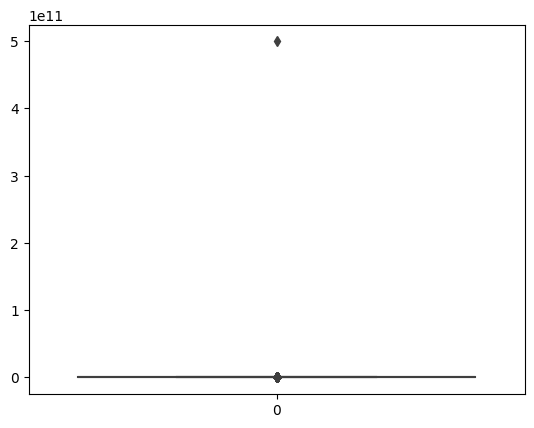

In [9]:
sns.boxplot(data['mileage'])
plt.show()

There is a significant outlier showing 500 trillion miles we will remove that from our data set

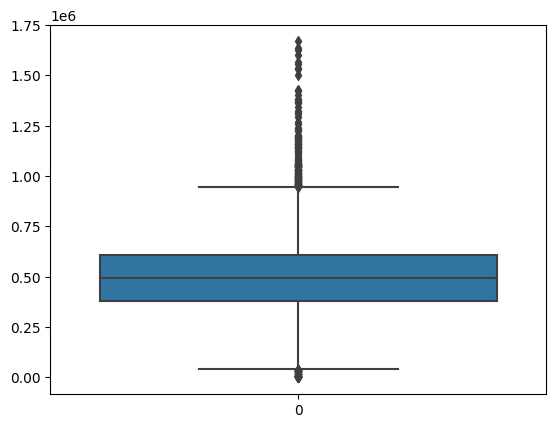

In [11]:
data = data[data['mileage']<2000000]
sns.boxplot(data['mileage'])
plt.show()